<a href="https://colab.research.google.com/github/khkarim19/Diploma-Work/blob/main/diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Импорт датасета

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter
from tqdm import tqdm_notebook as tqdm

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from    keras.callbacks   import ModelCheckpoint

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/Reviews.csv', engine='python', encoding='utf-8', error_bad_lines=False)

<ipython-input-8-f6b2a5a94a47>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews = pd.read_csv('/content/drive/MyDrive/Reviews.csv', engine='python', encoding='utf-8', error_bad_lines=False)


In [ ]:
reviews.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
reviews.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

Пример отзыва

In [ ]:
reviews['Text'][434]

'I enjoy these chips. I got these instead of my usual jalapeno ones from the same company for a bit of flavor change. I think those are better but only slightly, like the jalapenos there is a great amount of flavor without being too overpowering. The small bag size prevents you from overeating as with a larger bag.'

In [ ]:
reviews['Summary'][434]

'Quite good'

Базовая статистика

In [ ]:
print("Кол-во уникальных товаров: ",len(reviews['ProductId'].unique()))

Кол-во уникальных товаров:  74258


In [ ]:
print("Кол-во уникальных пользователей: ", len(reviews['UserId'].unique()))

Кол-во уникальных пользователей:  256059


In [ ]:
print("Число уникальных отзывов: ", len(reviews['Text'].unique()))

Число уникальных отзывов:  393579


# 2) Препроцессинг (токенизация)

Группирую для проверки на одинаковые отзывы

In [ ]:
reviews.groupby(by=['UserId', 'ProductId']).count().sort_values(by=['Text'],ascending=False).head(5)

Id  ProfileName  HelpfulnessNumerator  \
UserId         ProductId                                           
A29JUMRL1US6YP B000WFKWDI  11           11                    11   
               B000WFU8O6  11           11                    11   
               B000WFN0VO  11           11                    11   
               B000WFORH0  11           11                    11   
               B000WFKI82  11           11                    11   

                           HelpfulnessDenominator  Score  Time  Summary  Text  
UserId         ProductId                                                       
A29JUMRL1US6YP B000WFKWDI                      11     11    11       11    11  
               B000WFU8O6                      11     11    11       11    11  
               B000WFN0VO                      11     11    11       11    11  
               B000WFORH0                      11     11    11       11    11  
               B000WFKI82                      11     11    11       11    11

Количество повторений в данных:

In [ ]:
((reviews.groupby(by=['UserId', 'ProductId']).count().sort_values(by=['Text'],ascending=False)>1)==True).sum()

Id                        5859
ProfileName               5859
HelpfulnessNumerator      5859
HelpfulnessDenominator    5859
Score                     5859
Time                      5859
Summary                   5859
Text                      5859
dtype: int64

In [ ]:
reviews.shape

(568454, 10)

Удалим дубликаты

In [ ]:
reviewsNoDuplicates = reviews.drop_duplicates(subset=['UserId', 'ProductId'], keep = 'first', inplace = False)
reviewsNoDuplicates.shape

(560804, 10)

Переведем время из unix Формата (количество секунд с 1 января 1970 года) в формат ГГГГ-ММ-ДД

In [ ]:
reviewsNoDuplicates['Time_converted']=reviewsNoDuplicates['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m-%d'))

In [ ]:
#Самый первый отзыв
reviewsNoDuplicates['Time_converted'].min()

'1999-10-08'

In [ ]:
#Последний отзыв
reviewsNoDuplicates['Time_converted'].max()

'2012-10-26'

Удалим остатки html разметки в данных

In [ ]:
def clean_html(col):
  if (('<span' not in col.lower()) or ('<href' not in col.lower())):
    return col.lower()

reviewsNoDuplicates['Text_new']=reviewsNoDuplicates['Text'].apply(clean_html)
reviewsNoDuplicates.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
Time_converted             0
Text_new                   0
dtype: int64

Удалим пропуски данных (NaN)

In [ ]:
reviewsNoDuplicates.dropna(inplace=True)

Уберем лишние слова (не несущие смысла) и спец. символы из отзывов.

In [ ]:
stop_words =[]
for word in open('stopwords.txt'):
  stop_words.append(word.replace('\n', ''))
stop_words = list(set(stop_words))
print('Кол-во слов', len(stop_words))

special_char_list=['\\','`','\"',"'",'*','_','{','}','[',']','(',')',';','@','^','&','>','#','+',':','-','_','=','|','>','<','~','.','!','$','/',',','?','%','0','1','2','3','4','5','6','7','8','9']

def remove_specialchars(col):
  for word in special_char_list:
    if word in col:
      col = col.replace(word,"").replace("  "," ")
  return col

def remove_stopwords(col):
  col_list=[]
  text_col_split = col.lower().replace('\n'," ").strip().split(" ")

  for word_ in text_col_split:
    if ( (word_ not in stop_words) and len(word)>3 ):
      col_list.append(word_)
  return col_list


Кол-во слов 638


In [ ]:
reviewsNoDuplicates["Text_new2"]=reviewsNoDuplicates['Text_new'].apply(remove_specialchars)

In [ ]:
reviewsNoDuplicates["Text_new2"]=reviewsNoDuplicates['Text_new2'].apply(remove_stopwords)

Пример отзыва после "очистки"

In [ ]:
print(reviewsNoDuplicates['Text_new2'][0])

['bought', 'vitality', 'canned', 'dog', 'food', 'products', 'good', 'quality', 'product', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


Анализ-сегментация

Text(0.5, 1.0, 'Распределение длины отзывов')

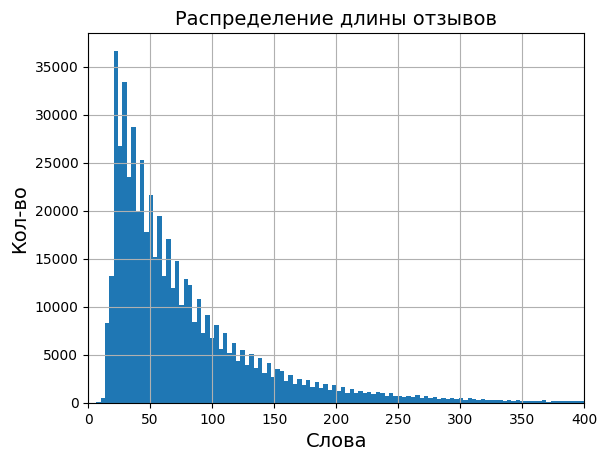

In [ ]:
reviewsNoDuplicates['Text_lenght']=reviewsNoDuplicates['Text'].apply(lambda col: len(col.split(' ')))
reviewsNoDuplicates['Text_lenght'].hist(bins=1000)
plt.xlim(0,400)
plt.xlabel('Слова', fontsize=14);
plt.ylabel('Кол-во',fontsize=14);
plt.title('Распределение длины отзывов',fontsize=14)

In [ ]:
reviewsNoDuplicates.to_csv('reviewsNoDuplicates.csv', index=False)

In [ ]:
user_number_review=reviewsNoDuplicates.groupby(by=['UserId']).count().sort_values(by=['Text'],ascending=False)
user_number_review.head()

,Id,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Time_converted,Text_new,Text_new2,Text_lenght
UserId,,,,,,,,,,,,,
A3OXHLG6DIBRW8,420,420,420,420,420,420,420,420,420,420,420,420,420
AY12DBB0U420B,382,382,382,382,382,382,382,382,382,382,382,382,382
A281NPSIMI1C2R,321,321,321,321,321,321,321,321,321,321,321,321,321
A1YUL9PCJR3JTY,309,309,309,309,309,309,309,309,309,309,309,309,309
A1Z54EM24Y40LL,251,251,251,251,251,251,251,251,251,251,251,251,251


In [ ]:
user_top_reviewer=user_number_review[user_number_review['Id']>10][['Id']]
user_top_reviewer.head(10)

,Id
UserId,
A3OXHLG6DIBRW8,420
AY12DBB0U420B,382
A281NPSIMI1C2R,321
A1YUL9PCJR3JTY,309
A1Z54EM24Y40LL,251
A2MUGFV2TDQ47K,201
AQQLWCMRNDFGI,167
AZV26LP92E6WU,167
A1UQBFCERIP7VJ,157


Text(0.5, 1.0, 'Отношение количества отзывов к рецензентам')

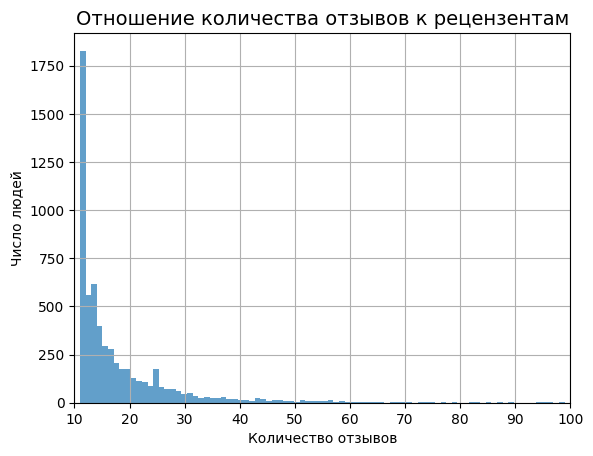

In [ ]:
user_top_reviewer['Id'].hist(bins=400,label='Кол-во отзывов рецензентов',alpha=0.7)
plt.xlabel('Количество отзывов')
plt.ylabel('Число людей')
plt.xlim(10,100)
plt.title('Отношение количества отзывов к рецензентам',fontsize=14)

In [ ]:
user_top_reviewer['Id'].describe()

count    6104.000000
mean       19.759174
std        17.420741
min        11.000000
25%        12.000000
50%        15.000000
75%        21.000000
max       420.000000
Name: Id, dtype: float64

In [ ]:
user_top_reviewer.to_csv('top_reviewer_list')

In [ ]:
user_average_info=reviewsNoDuplicates.groupby(by=['UserId']).mean()


<ipython-input-30-77a6ed5cee81>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  user_average_info=reviewsNoDuplicates.groupby(by=['UserId']).mean()


In [ ]:
user_average_info.to_csv('amazon_reviewer_avg_info.csv')
top_reviewer_avg_data=pd.merge(user_average_info,user_top_reviewer,how='inner',on='UserId')
user_top_reviewer.head()

,Id
UserId,
A3OXHLG6DIBRW8,420
AY12DBB0U420B,382
A281NPSIMI1C2R,321
A1YUL9PCJR3JTY,309
A1Z54EM24Y40LL,251


In [ ]:
user_average_info.head()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght
UserId,,,,,,
#oc-R103C0QSV1DF5E,136323.0,1.0,2.0,5.0,1.343088e+09,56.0
#oc-R109MU5OBBZ59U,516062.0,0.0,1.0,5.0,1.350086e+09,21.0
#oc-R10LFEMQEW6QGZ,516079.0,0.0,1.0,5.0,1.345939e+09,85.0
#oc-R10LT57ZGIB140,378693.0,0.0,0.0,3.0,1.310602e+09,45.0
#oc-R10UA029WVWIUI,136545.0,0.0,0.0,1.0,1.342483e+09,66.0


In [ ]:
# calculate rtio of helpfulness, average number of people finding review helpful over total count commented on review
top_reviewer_avg_data['ratio_helpful']=top_reviewer_avg_data['HelpfulnessNumerator']/top_reviewer_avg_data['HelpfulnessDenominator']
top_reviewer_avg_data['Time_converted']=top_reviewer_avg_data['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))
#making sure ratio of helpfulness between 0-1

top_reviewer_avg_data=top_reviewer_avg_data[(top_reviewer_avg_data['ratio_helpful']>0.0) & (top_reviewer_avg_data['ratio_helpful']<1.0)]
colors = np.random.rand(top_reviewer_avg_data.shape[0])
top_reviewer_avg_data.head()

,Id_x,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_lenght,Id_y,ratio_helpful,Time_converted
UserId,,,,,,,,,
A100WO06OQR8BQ,295215.290909,0.836364,2.418182,3.109091,1.315171e+09,166.418182,55,0.345865,2011-09
A101P2KHWCU0G6,306505.230769,0.346154,1.653846,2.038462,1.338788e+09,287.923077,26,0.209302,2012-06
A102UXGLDF76G1,262626.636364,0.363636,0.545455,4.818182,1.243296e+09,91.272727,11,0.666667,2009-05
A1051DBTLWP5A2,243877.961538,1.000000,1.038462,4.615385,1.323053e+09,188.615385,26,0.962963,2011-12
A105S56ODHGJEK,296723.888889,0.111111,0.555556,3.222222,1.286256e+09,159.666667,18,0.200000,2010-10


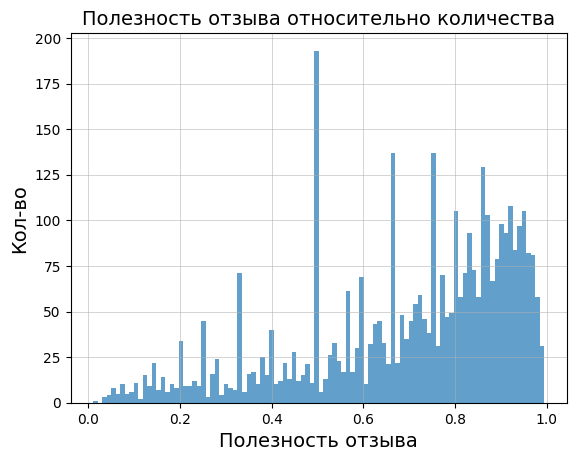

In [ ]:
# review helpfulness distribution
top_reviewer_avg_data['ratio_helpful'].hist(bins=100,label='review helpfullness top reviewers',alpha=0.7);

plt.xlabel('Полезность отзыва',fontsize=14);
plt.ylabel('Кол-во',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Полезность отзыва относительно количества',fontsize=14);
plt.savefig('helpfullness_top_reviewer_dist.png')

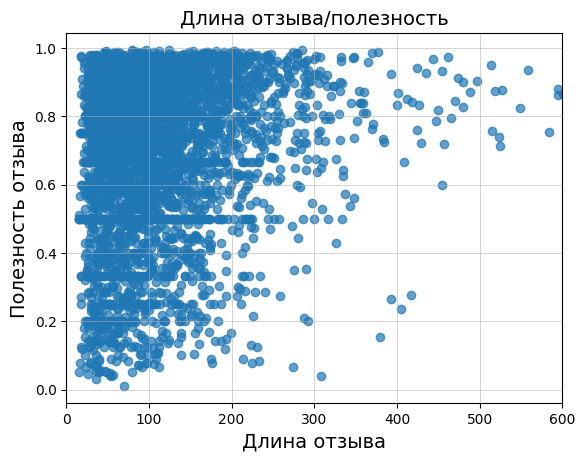

In [ ]:
# review length vs helpfulness
plt.scatter(top_reviewer_avg_data['Text_lenght'],top_reviewer_avg_data['ratio_helpful'],alpha=0.7);
plt.xlim(0,600);
plt.xlabel('Длина отзыва',fontsize=14);
plt.ylabel('Полезность отзыва',fontsize=14);
#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Длина отзыва/полезность',fontsize=14);
plt.savefig('helpfullness_top_reviewer_length.png')

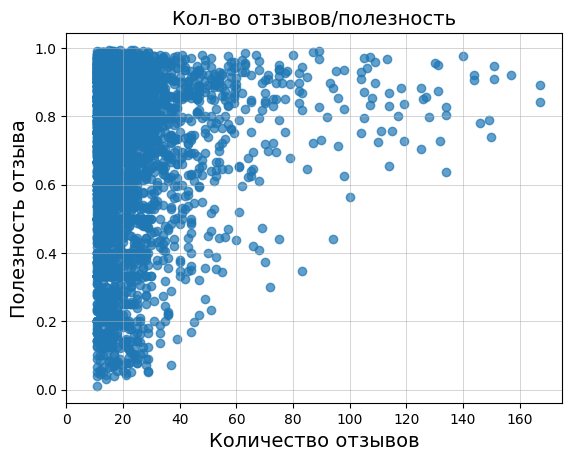

In [ ]:
#review helpfulness vs. review count
plt.scatter(top_reviewer_avg_data['Id_y'],top_reviewer_avg_data['ratio_helpful'],alpha=0.7);
plt.xlim(0,175);
plt.xlabel('Количество отзывов',fontsize=14);
plt.ylabel('Полезность отзыва',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Кол-во отзывов/полезность',fontsize=14);
plt.savefig('helpfullness_top_reviewer_count.png')

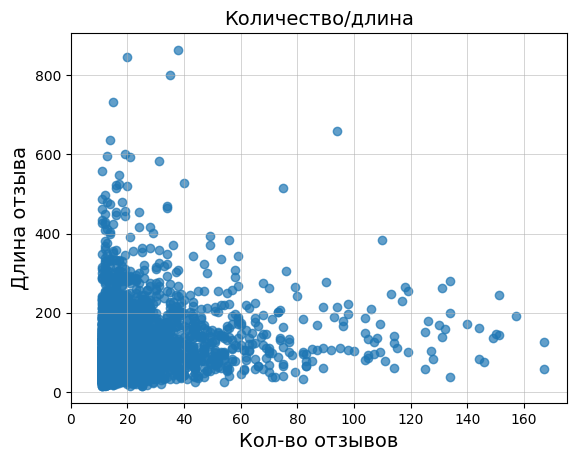

In [ ]:
#revire count of top reviewers vs. review length
plt.scatter(top_reviewer_avg_data['Id_y'],top_reviewer_avg_data['Text_lenght'],alpha=0.7); #,c=top_reviewer_avg_data['ratio_helpful'])
plt.xlim(0,175);

plt.xlabel('Кол-во отзывов',fontsize=14);
plt.ylabel('Длина отзыва',fontsize=14);

#plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)


plt.title('Количество/длина',fontsize=14);
plt.savefig('helpfullness_top_reviewer_length_count.png')

# Подготовка датасета под анализ сентиментов

In [ ]:
def score_pos_neg(col):
  # 1 для рейтинга 4 и
  if col>3:
    return 1
  else:
    return 0
reviewsNoDuplicates['score_pos_neg']=reviewsNoDuplicates['Score'].apply(score_pos_neg)

In [ ]:

reviewsCleaned = reviewsNoDuplicates[['Score','Time_converted','Text_new2','score_pos_neg']]
reviewsCleaned = reviewsCleaned.rename(columns={'Text_new2':'Review_words'})
reviewsCleaned['Time_converted']=reviewsNoDuplicates['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))
reviewsCleaned.head()

,Score,Time_converted,Review_words,score_pos_neg
0,5,2011-04,"[bought, vitality, canned, dog, food, products...",1
1,1,2012-09,"[product, arrived, labeled, jumbo, salted, pea...",0
2,4,2008-08,"[confection, centuries, light, pillowy, citrus...",1
3,2,2011-06,"[secret, ingredient, robitussin, addition, roo...",0
4,5,2012-10,"[great, taffy, great, price, wide, assortment,...",1


In [ ]:
reviewsCleaned.to_csv('reviewsCleaned.csv', index=False)

# Анализ сентимента


*   В этом разделе анализ выполняется для текста рецензии (теперь в виде списка) и оценки рецензии как положительной, так и отрицательной
*   Первым шагом является сбор слов для всех отзывов, положительных отзывов и отрицательных отзывов отдельно в словаре
*Наиболее распространенные слова проверяются в положительной и отрицательной группах
*Вычисляется полярность слов, представляющая собой отношение распространенности слов в положительных отзывах к отрицательным отзывам, и наносятся на график слова с аналогичной полярностью
*Топ-10000 наиболее распространенных слов, используемых в нашем словаре. Этот словарь проиндексирован для векторизации каждого обзора
*Для каждого обзора первые 200 слов рассматриваются только на основе распределения, векторы дополняются соответствующим образом
*Для учета несбалансированного размера отзыва используется четное количество рецензий "1" и "0" (по 75000) каждая)
*Данные разделяются на обучающий/тестовый набор
Модель обучается с использованием глубокого обучения, с одним слоем встраивания и двумя стеками GRU (gated recurrent unit) и одним плотным слоем с сигмоидной функцией


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter
from tqdm import tqdm_notebook as tqdm

import keras
from keras.utils import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from    keras.callbacks   import ModelCheckpoint

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [ ]:
reviewsCleaned = pd.read_csv('/content/drive/MyDrive/reviewsCleaned.csv', engine='python', encoding='utf-8', error_bad_lines=False)

<ipython-input-19-5d813da3ea0c>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviewsCleaned = pd.read_csv('/content/drive/MyDrive/reviewsCleaned.csv', engine='python', encoding='utf-8', error_bad_lines=False)


Text(0.5, 1.0, 'Количество отзывов за весь период')

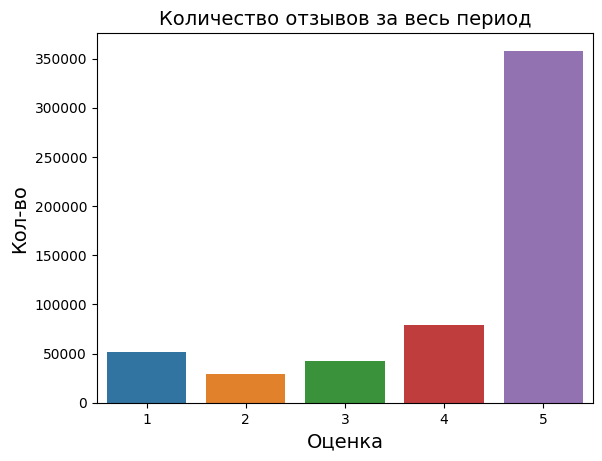

In [ ]:
sns.countplot(x='Score', data=reviewsCleaned);
plt.xlabel('Оценка', fontsize=14);
plt.ylabel('Кол-во',fontsize=14);
plt.title('Количество отзывов за весь период',fontsize=14)


Исследования отзывов рецензентов с более чем 10 обзорами

In [ ]:
reviewsLite3 = reviewsCleaned[0:100]

In [ ]:
reviewsLite3.head()

,Score,Time_converted,Review_words,score_pos_neg
0,5,2011-04,"['bought', 'vitality', 'canned', 'dog', 'food'...",1
1,1,2012-09,"['product', 'arrived', 'labeled', 'jumbo', 'sa...",0
2,4,2008-08,"['confection', 'centuries', 'light', 'pillowy'...",1
3,2,2011-06,"['secret', 'ingredient', 'robitussin', 'additi...",0
4,5,2012-10,"['great', 'taffy', 'great', 'price', 'wide', '...",1


In [ ]:
reviewsCleaned['Review_words']=reviewsCleaned['Review_words'].apply(lambda x: eval(x))

In [ ]:
pos_count = Counter()
neg_count = Counter()
total_count = Counter()

In [ ]:
review_vec = reviewsCleaned['Review_words']
score_vec = reviewsCleaned['score_pos_neg']
actual_score_vec = reviewsCleaned['Score']

Отрицательный отзыв

In [ ]:
for i,review in enumerate(review_vec):

  if (i>10 and i<16 and score_vec[i]==0 and actual_score_vec[i]!=3):
    print('Negative, review score:', actual_score_vec[i], '\n')
    print(review)
    print('\n')

Negative, review score: 1 

['cats', 'happily', 'eating', 'felidae', 'platinum', 'years', 'new', 'bag', 'shape', 'food', 'new', 'food', 'bowls', 'bowls', 'sit', 'full', 'kitties', 'will', 'not', 'touch', 'food', 'ive', 'noticed', 'similar', 'reviews', 'formula', 'changes', 'unfortunately', 'need', 'find', 'new', 'food', 'cats', 'will', 'eat']




Положительный отзыв

In [ ]:
for i,review in enumerate(review_vec):

  if (i>11 and i<15 and actual_score_vec[i]==5):
    print('Positive, review score:', actual_score_vec[i], '\n')
    print(review)
    print('\n')

Positive, review score: 5 

['strawberry', 'twizzlers', 'guilty', 'pleasure', 'yummy', 'pounds', 'will', 'son']




Счетчик слов

In [ ]:
for i in tqdm(range(len(review_vec))):
  try:
    for word in review_vec[i]:
      total_count[word]+=1
      if (score_vec[i]==1):
        pos_count[word]+=1
      if(score_vec[i]==0):
        neg_count[word]+=1
  except:
     continue

<ipython-input-28-2ef9462905fc>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(review_vec))):


  0%|          | 0/560388 [00:00<?, ?it/s]

In [ ]:
# Топ 20 слов в плохих отзывах
neg_count.most_common()[0:20]

[('not', 117394),
 ('like', 68473),
 ('taste', 49301),
 ('product', 45141),
 ('coffee', 38648),
 ('good', 38467),
 ('flavor', 34803),
 ('will', 30477),
 ('no', 27998),
 ('food', 27022),
 ('tea', 25483),
 ('buy', 20925),
 ('amazon', 17527),
 ('better', 17436),
 ('again', 17404),
 ('time', 17357),
 ('box', 16800),
 ('dog', 16407),
 ('water', 15809),
 ('great', 15632)]

In [ ]:
# Топ 20 слов в хороших отзывах
pos_count.most_common()[0:20]

[('not', 207889),
 ('like', 178215),
 ('good', 153115),
 ('great', 145364),
 ('coffee', 119847),
 ('taste', 114447),
 ('love', 109636),
 ('flavor', 104099),
 ('tea', 104089),
 ('product', 99629),
 ('will', 93568),
 ('food', 89946),
 ('no', 75087),
 ('use', 67065),
 ('best', 66555),
 ('time', 62180),
 ('amazon', 59952),
 ('find', 59420),
 ('price', 58940),
 ('ive', 57715)]

In [ ]:
counter_pos_neg=Counter()

for word, count in tqdm(total_count.most_common()):
  if(count>100):
    try:
      counter_pos_neg[word]=np.log(pos_count[word]/float(neg_count[word]+1))
    except:
      continue

<ipython-input-31-52904dd431f6>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word, count in tqdm(total_count.most_common()):


  0%|          | 0/223135 [00:00<?, ?it/s]

Самые различные слова

In [ ]:
dict_top_pos=dict(counter_pos_neg.most_common(40))


In [ ]:
dict_top_neg=dict(counter_pos_neg.most_common()[:-40:-1])

In [ ]:
dict_top_pos

{'hears': 5.537334267018537,
 'cee': 4.941642422609304,
 'listmania': 4.912654885736052,
 'soninlaw': 4.787491742782046,
 'snackimals': 4.700480365792417,
 'excellant': 4.629862798578463,
 'stuf': 4.382026634673881,
 'cakesters': 4.2243976904702984,
 'winwin': 4.208417018481948,
 'autodelivery': 3.9576335166801986,
 'overfeed': 3.9318256327243257,
 'acv': 3.791736839553644,
 'masterpiece': 3.7455747977904816,
 'asin': 3.6888794541139363,
 'hooked': 3.6159184666016686,
 'yum': 3.5566578193714773,
 'commands': 3.502549875922443,
 'trimester': 3.447717397297048,
 'tommy': 3.417726683613366,
 'waits': 3.4153820166541116,
 'prefect': 3.3843902633457743,
 'mmmmmm': 3.367295829986474,
 'smiles': 3.339321977944068,
 'besttasting': 3.2851984677992734,
 'dancing': 3.2733640101522705,
 'soothes': 3.2733640101522705,
 'guilt': 3.265759410767051,
 'alvita': 3.258096538021482,
 'sweats': 3.258096538021482,
 'teachers': 3.248434627109745,
 'delicous': 3.241475656785442,
 'lifesaver': 3.23998478807843

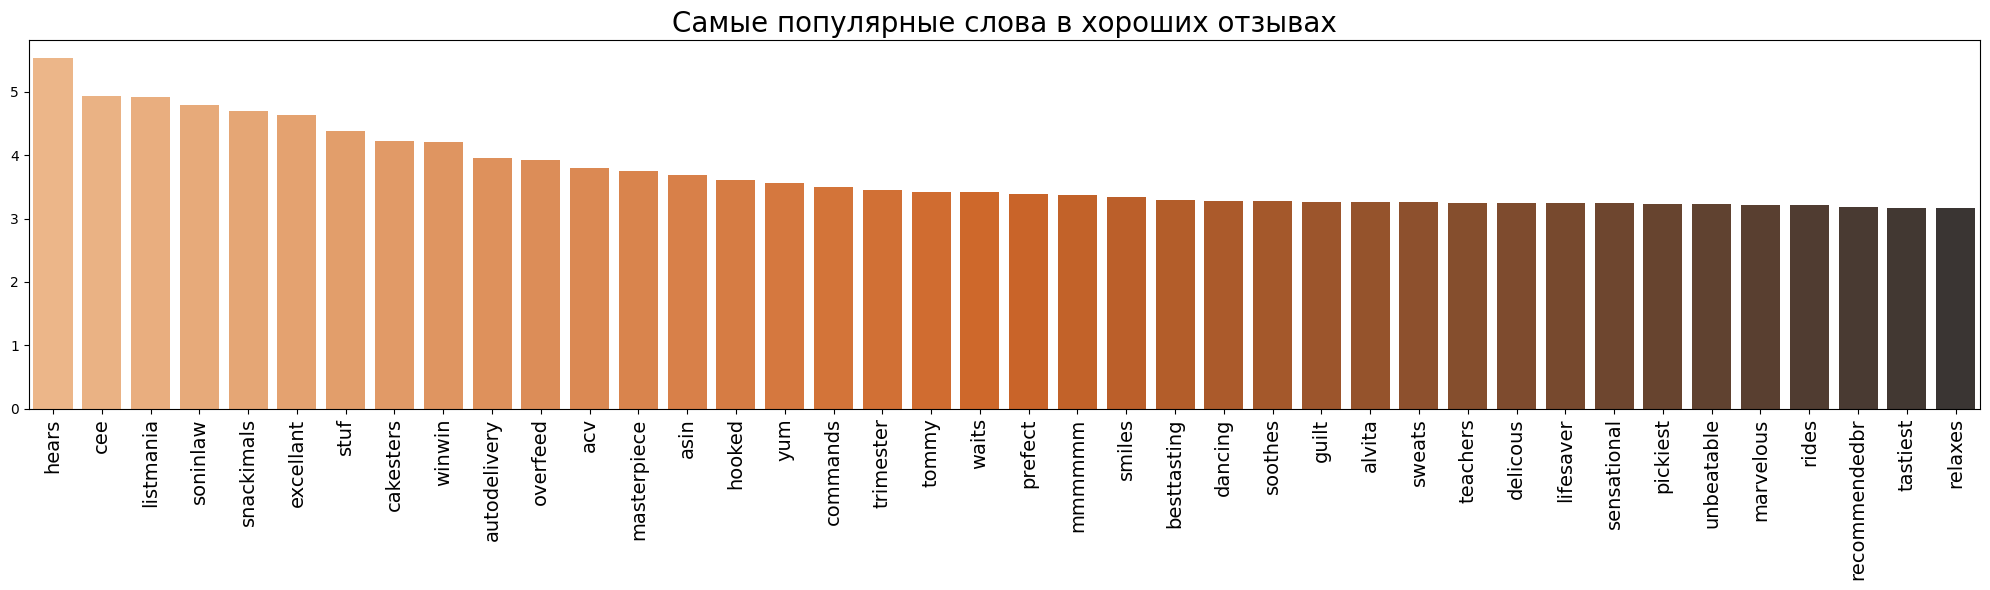

In [ ]:
plt.figure(figsize=(20,6))
sns.barplot(x=list(dict_top_pos.keys()), y=list(dict_top_pos.values()), palette="Oranges_d")
plt.xticks(rotation=90,fontsize=14)
plt.title('Самые популярные слова в хороших отзывах', fontsize=20)
plt.tight_layout();
plt.savefig('word__freq_pos_rev.png')


Есть такие слова как masterpiece (шедевр), excellent (превосходно), perfect (отлично)

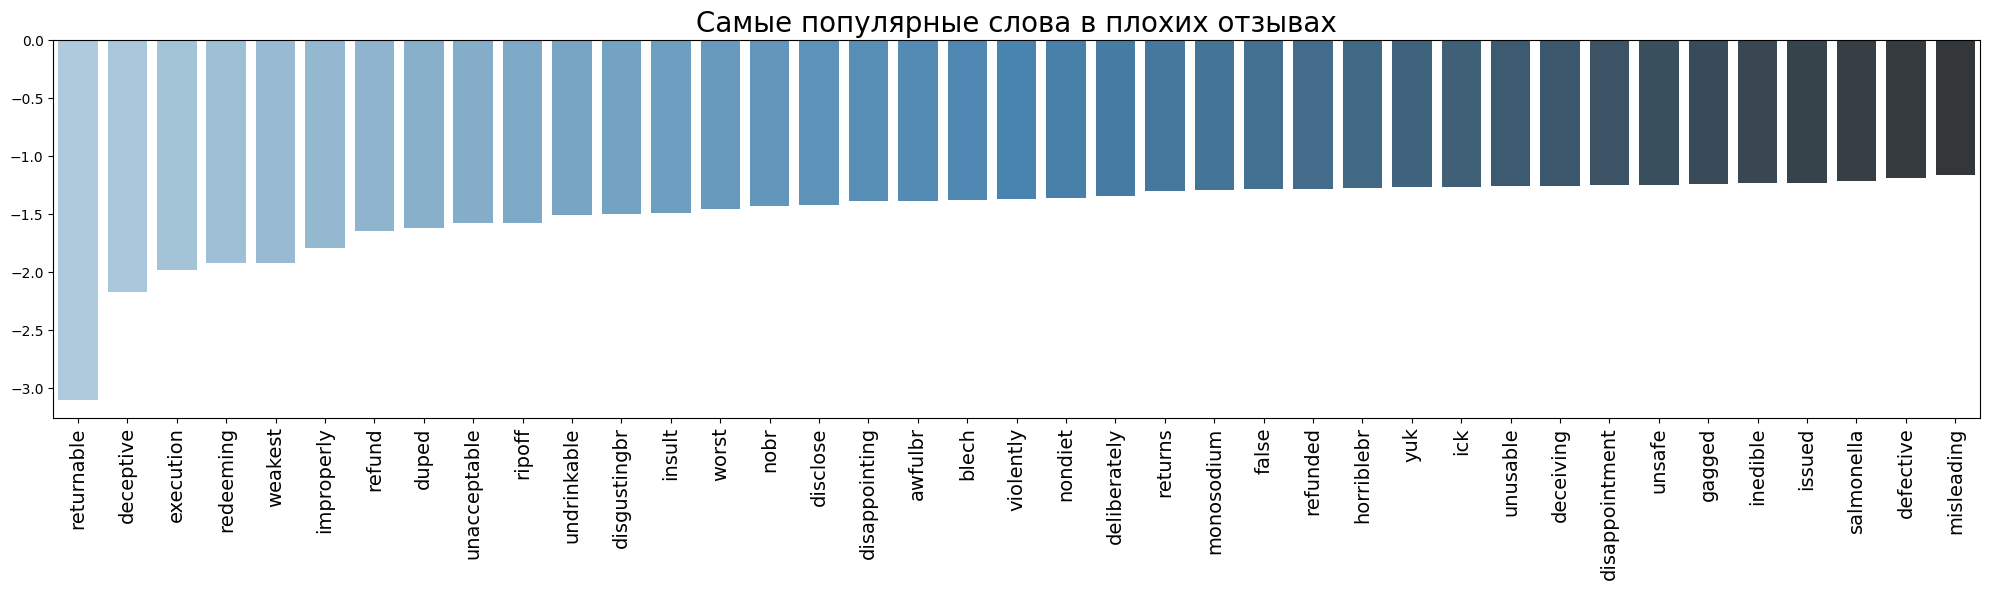

In [ ]:
plt.figure(figsize=(20,6))
sns.barplot(x=list(dict_top_neg.keys()), y=list(dict_top_neg.values()), palette="Blues_d")
plt.xticks(rotation=90,fontsize=14)
plt.title('Самые популярные слова в плохих отзывах', fontsize=20)
plt.tight_layout();
plt.savefig('word__freq_neg_rev.png')

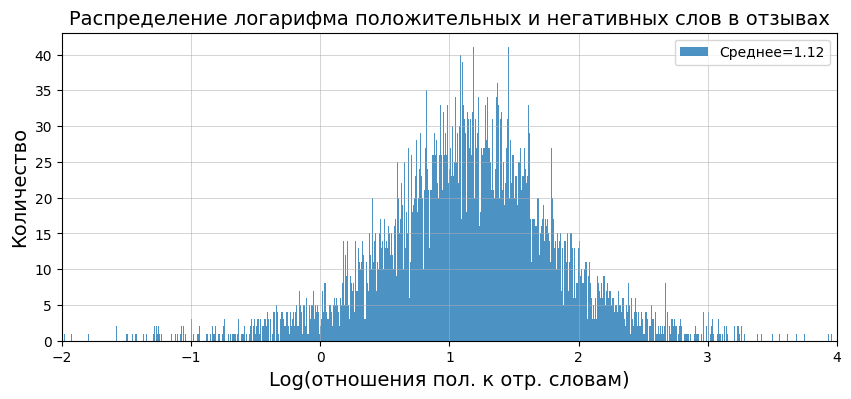

In [ ]:
plt.figure(figsize=(10,4));
plt.hist(counter_pos_neg.values(),bins=2000,label='Среднее=1.12',alpha=0.8);
plt.xlim(-2,4)

plt.xlabel('Log(отношения пол. к отр. словам)',fontsize=14)
plt.ylabel('Количество',fontsize=14)
plt.title('Распределение логарифма положительных и негативных слов в отзывах',fontsize=14)
plt.grid(linewidth=0.5,alpha=0.75)
plt.legend(loc='upper right');
plt.savefig('distribution_log_pos_neg_word_review.png')

# Используем только 10000 самых часто встречающихся слов

In [ ]:
top10k_dict = dict(total_count.most_common()[0:10000])
top10k_list = (list(top10k_dict.keys()))
len(top10k_list)

10000

Сопоставим каждому слову число (индекс) для более удобного дальнейшего анализа

In [ ]:
word_to_index={}
index_to_word={}

for i,word in enumerate(top10k_list):
  word_to_index[word]=i
for word, i in word_to_index.items():
  index_to_word[i]=word


In [ ]:
review_vec_index = []
review_label = []
review_score = []

for i in tqdm(range(len(review_vec))):
  len_rev=len(review_vec[i])
  if (len_rev>0 and len_rev<1750): #удалим слишком короткие и очень длинные отзывы
    indices = set()
    for word in review_vec[i]:
      if word in word_to_index.keys():
        indices.add(word_to_index[word])
    review_vec_index.append(list(indices))
    review_label.append(score_vec[i])
    review_score.append(actual_score_vec[i])

print(len(review_vec_index), len(review_label), len(review_score))


<ipython-input-40-7d22eacad5d4>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(review_vec))):


  0%|          | 0/560388 [00:00<?, ?it/s]

560381 560381 560381


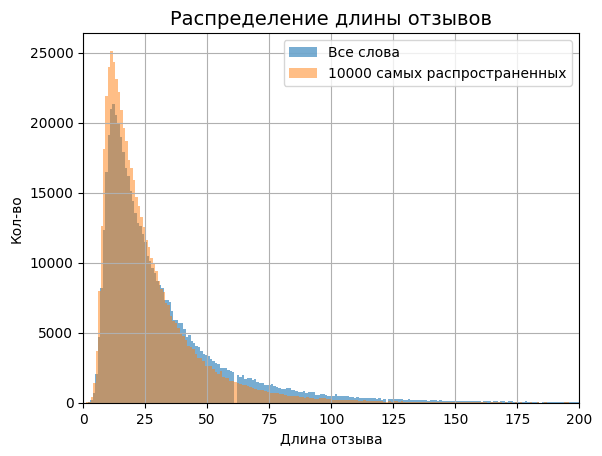

In [ ]:
review_len_vec = pd.Series(review_vec).apply(lambda x: len(x))
review_len_vec_index = pd.Series(review_vec_index).apply(lambda x: len(x))

review_len_vec.hist(bins=1750,alpha=0.6,label='Все слова');
review_len_vec_index.hist(bins=589,alpha=0.5,label="10000 самых распространенных")
plt.xlim(0,200)
plt.xlabel("Длина отзыва")
plt.ylabel("Кол-во")
plt.title("Распределение длины отзывов",fontsize=14);
plt.legend()
plt.savefig('review_lenght_dist_before_after')


In [ ]:
review_len_vec.describe() #до

count    560388.000000
mean         32.932249
std          32.912147
min           0.000000
25%          14.000000
50%          23.000000
75%          40.000000
max        1722.000000
Name: Review_words, dtype: float64

In [ ]:
review_len_vec_index.describe() # после выборки 10000 слов

count    560381.000000
mean         25.727096
std          20.723995
min           1.000000
25%          13.000000
50%          20.000000
75%          32.000000
max         590.000000
dtype: float64

<Axes: >

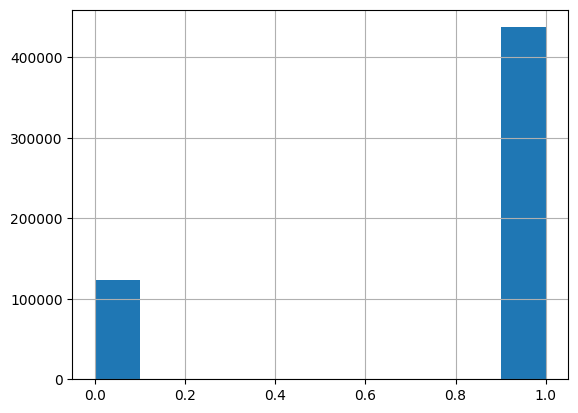

In [ ]:
score_vec.hist()

In [ ]:
# список в массив
review_score=np.array(review_score)
review_vec_index=np.array(review_vec_index)
review_vec_index

<ipython-input-46-dedcce3cf307>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  review_vec_index=np.array(review_vec_index)


array([list([32, 1, 2, 353, 8260, 6, 873, 4746, 11, 4843, 78, 1422, 2236, 22, 23, 247, 284, 62]),
       list([64, 0, 1187, 965, 6, 3273, 1803, 1774, 174, 7438, 1650, 2770, 5372, 735]),
       list([0, 9345, 384, 525, 2710, 1943, 29, 1949, 161, 6695, 42, 173, 303, 304, 947, 449, 327, 2126, 81, 1492, 4440, 7385, 7518, 862, 115, 1652, 7414, 5111, 1788, 2175]),
       ...,
       list([0, 1, 130, 7, 10, 11, 23, 34, 290, 2212, 1063, 40, 564, 57, 188, 6974, 64, 68, 2376, 1625, 355, 5607, 492, 763]),
       list([513, 2, 34, 581, 3750, 7049, 46, 17, 786, 81, 564, 148, 118, 23, 5397, 57]),
       list([545, 6, 679, 424, 2219, 13, 885, 1080, 159])], dtype=object)

In [ ]:
def sentence_to_vector(sentence):
    words = sentence.split()
    vec = [word_to_index[word] for word in words if word in word_to_index]
    vec = np.hstack([np.zeros(100-len(vec)), vec])
    vec = vec.astype(int)
    return vec
sentence_to_vector('cake was very tasty')

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 403, 107])

# Используем четное число отзывов для классификации
* Из за нечетного числа 5-звездочных отзывов, рассмотрим только по 75000 отзывов обоих классов
* Включим в датасет 1, 2, 4, 5 звездочные отзывы. 3 звездочные в силу их нейтральности рассматривать не будем.

In [ ]:
max_count=75000
counter_pos=0
counter_neg=0
review_vec_index_even=[]
review_label_even=[]
review_score_even=[]

for i in tqdm(range(len(review_score))):
  if((review_score[i]==5 or review_score[i]==4) and counter_pos<max_count):

    review_vec_index_even.append(review_vec_index[i])
    review_label_even.append(review_label[i])
    review_score_even.append(review_score[i])
    counter_pos=counter_pos+1

  if((review_score[i]==1 or review_score[i]==2) and counter_neg<max_count):
    review_vec_index_even.append(review_vec_index[i])
    review_label_even.append(review_label[i])
    review_score_even.append(review_score[i])
    counter_neg=counter_neg+1

<ipython-input-48-6e6666ea7463>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(review_score))):


  0%|          | 0/560381 [00:00<?, ?it/s]

Посмотрим на распределение рейтинга отзывов

<Axes: >

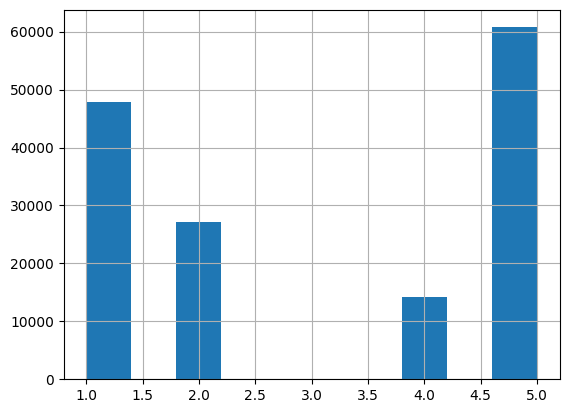

In [ ]:
pd.Series(review_score_even).hist()

Посмотрим на количество элементов в двух классах

<Axes: >

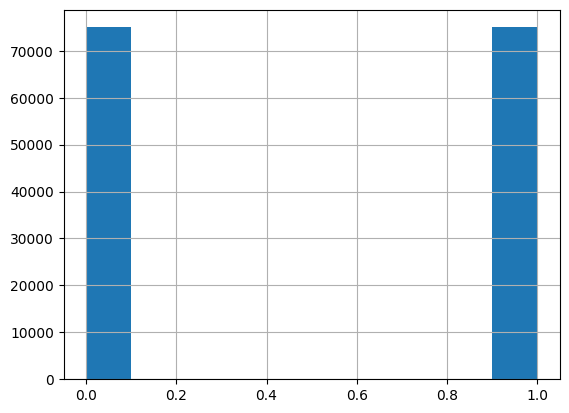

In [ ]:
pd.Series(review_label_even).hist()

Заполнение вектора отзывом длины 100 с помощью библиотеки Keras

In [ ]:
review_vec_index_pad=pad_sequences(review_vec_index_even,maxlen=100)
review_label=np.array(review_label_even)


In [ ]:
review_vec_index_pad

array([[   0,    0,    0, ...,  247,  284,   62],
       [   0,    0,    0, ..., 2770, 5372,  735],
       [   0,    0,    0, ..., 5111, 1788, 2175],
       ...,
       [   0,    0,    0, ...,  746,  881,  628],
       [   0,    0,    0, ...,  250, 5436, 7645],
       [   0,    0,    0, ..., 4507,  829, 1439]], dtype=int32)

In [ ]:
review_label

array([1, 0, 1, ..., 0, 0, 0])

Разделим данные на тестовую и обучающую выборки

In [ ]:
# Сохраним входные данные
model_data_input = pd.DataFrame(dict(X_even=review_vec_index_pad.tolist(),y_even=review_label))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(review_vec_index_pad, review_label, test_size=0.33, random_state=42)

In [ ]:
model_data_input.to_csv('model_data_input_even.csv',index=False)


# Глубокое обучение:
* Размер словаря 10000
* Один слой векторного представления преобразует каждый индекс в вектор размером 100
* На вход подается 100 слов за отзыв

#Используя Keras:
* были использованы 2 слоя GRU (в модели используются два слоя GRU, которые представляют собой специальный тип рекуррентных нейронных сетей. Они позволяют обработать последовательности данных и учесть их контекстную зависимость.) c функцией активации гиперболический тангенс чтобы избежать переобучения
* GRU был выбран из за скорости и точности


In [ ]:
model_data_input=pd.read_csv('/content/drive/MyDrive/model_data_input_even.csv')

# Архитектура модели

In [ ]:
max_feature=10000
max_len=100
embedding_dim=100
model=Sequential()
# слой векторного представления, индекс каждого слова сопоставляется с вектором размера 100
model.add(layers.Embedding(max_feature, embedding_dim,input_length=max_len))
# первый слой GRU. вход и выход размера 100, каждый вектор 32
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True))
# Второй слой GRU. На выход выдается 1 вектор размера 64
model.add(layers.GRU(64,activation='tanh',dropout=0.1,recurrent_dropout=0.5))
# последний слой полносвязный, который перемещает массив размера 64 на 1 плотным слоем и накладывает сверху сигмоиду
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 gru (GRU)                   (None, 100, 32)           12864     
                                                                 
 gru_1 (GRU)                 (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,031,745
Trainable params: 1,031,745
Non-trainable params: 0
_________________________________________________________________


Обучение модели

In [ ]:
model.compile(optimizer=Adam(lr=1e-3),loss='binary_crossentropy',metrics=['acc'])

callbacks_list=[keras.callbacks.ModelCheckpoint(filepath='model_bestrun_gru.h5',save_best_only=True, verbose=1,)]
history=model.fit(X_train,y_train, epochs=5,batch_size=128,validation_split=0.2,callbacks=callbacks_list)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


629/629 [==============================] - ETA: 0s - loss: 0.3306 - acc: 0.8565
Epoch 1: val_loss improved from inf to 0.27160, saving model to model_bestrun_gru.h5
629/629 [==============================] - 314s 487ms/step - loss: 0.3306 - acc: 0.8565 - val_loss: 0.2716 - val_acc: 0.8897
Epoch 2/5
629/629 [==============================] - ETA: 0s - loss: 0.2485 - acc: 0.9013
Epoch 2: val_loss improved from 0.27160 to 0.26816, saving model to model_bestrun_gru.h5
629/629 [==============================] - 320s 508ms/step - loss: 0.2485 - acc: 0.9013 - val_loss: 0.2682 - val_acc: 0.8934
Epoch 3/5
629/629 [==============================] - ETA: 0s - loss: 0.2231 - acc: 0.9136
Epoch 3: val_loss did not improve from 0.26816
629/629 [==============================] - 318s 506ms/step - loss: 0.2231 - acc: 0.9136 - val_loss: 0.2710 - val_acc: 0.8938
Epoch 4/5
629/629 [==============================] - ETA: 0s - loss: 0.2010 - acc: 0.9237
Epoch 4: val_loss did not improve from 0.26816
629/629

In [ ]:
model.save('my_model_endrun_gru.h5')
model_endrun_gru = keras.models.load_model('my_model_endrun_gru.h5')

# проверим точность на тестовой выборке
model_endrun_gru.evaluate(X_test,y_test)

1547/1547 [==============================] - 61s 39ms/step - loss: 0.2921 - acc: 0.8904


[0.29213187098503113, 0.8904242515563965]

In [ ]:
model_bestrun_gru = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/my_model_endrun_gru.h5')
model_bestrun_gru.evaluate(X_test, y_test)

1547/1547 [==============================] - 61s 39ms/step - loss: 0.2964 - acc: 0.8884


[0.29641062021255493, 0.8884242177009583]

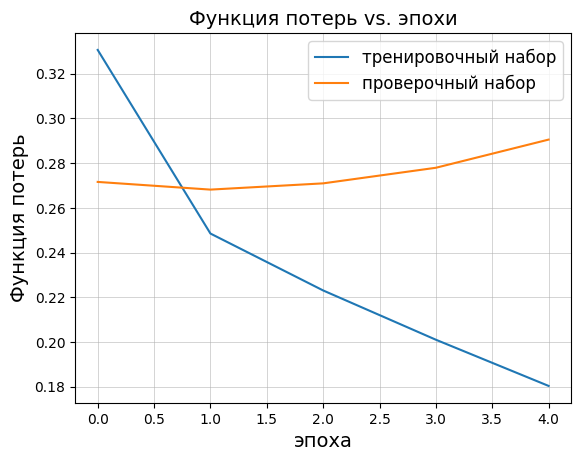

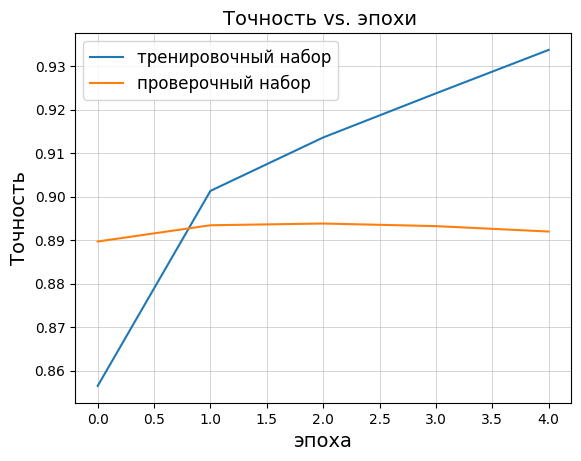

In [ ]:
list_epoch=np.arange(0,5)
plt.plot(list_epoch,history.history['loss'])
plt.plot(list_epoch,history.history['val_loss'])
plt.ylabel('Функция потерь',fontsize=14)
plt.xlabel('эпоха',fontsize=14)
plt.grid(linewidth=0.5,alpha=0.75)
plt.legend(['тренировочный набор','проверочный набор'],fontsize=12)
plt.title('Функция потерь vs. эпохи',fontsize=14)
plt.savefig('loss_epoch.png')
plt.show()


plt.plot(list_epoch,history.history['acc'])
plt.plot(list_epoch,history.history['val_acc'])
plt.ylabel('Точность',fontsize=14)
plt.legend(['тренировочный набор','проверочный набор'],fontsize=12)
plt.grid(linewidth=0.5,alpha=0.75)
plt.title('Точность vs. эпохи ',fontsize=14)
plt.xlabel('эпоха',fontsize=14)
plt.savefig('accuracy_epoch.png')
plt.show()

In [ ]:
# сохраним веса слоя векторного представления для дальнейшего анализа слов
embedding_matrix=model_bestrun_gru.layers[0].get_weights()[0]

In [ ]:
# сохраним предсказания для тестирования данных
prediction = model_bestrun_gru.predict(X_test)

1547/1547 [==============================] - 60s 38ms/step


In [ ]:
# сохраним вероятность
predict_prob=model_bestrun_gru.predict(X_test)
predict_proba=np.argmax(predict_prob,axis=1)

1547/1547 [==============================] - 76s 49ms/step


In [ ]:
prediction_proba=model_bestrun_gru.predict(X_test)

1547/1547 [==============================] - 61s 39ms/step


In [ ]:
prediction_round=np.round(prediction)
y_test_vec=y_test.reshape(y_test.shape[0],1)

#Метрики

In [ ]:
from sklearn.metrics import f1_score, auc, confusion_matrix, roc_curve, roc_auc_score,accuracy_score

In [ ]:
print('Точность: \n \n%0.2f'%accuracy_score(y_test_vec,prediction_round))
print('\nМатрица ошибок: \n \n', confusion_matrix(y_test_vec,prediction_round))
print('\n F1: \n \n %0.2f'% f1_score(y_test_vec,prediction_round))

Точность: 
 
0.89

Матрица ошибок: 
 
 [[22280  2541]
 [ 2982 21697]]

 F1: 
 
 0.89


In [ ]:

predict_prob_n = predict_prob.reshape(49500)

In [ ]:
# меняем размерность для AUC
y_test_vec_n=y_test_vec.reshape(49500)
prediction_proba_n=prediction_proba.reshape(49500)

In [ ]:
#сохраним матрицу ошибок

cm=confusion_matrix(y_test_vec, prediction_round)

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормализованная матрица ошибок")
    else:
        print('Матрица ошибок')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Действительность')
    plt.xlabel('Предсказание')
    plt.savefig('confusion_matrix.png')

Матрица ошибок
[[22280  2541]
 [ 2982 21697]]


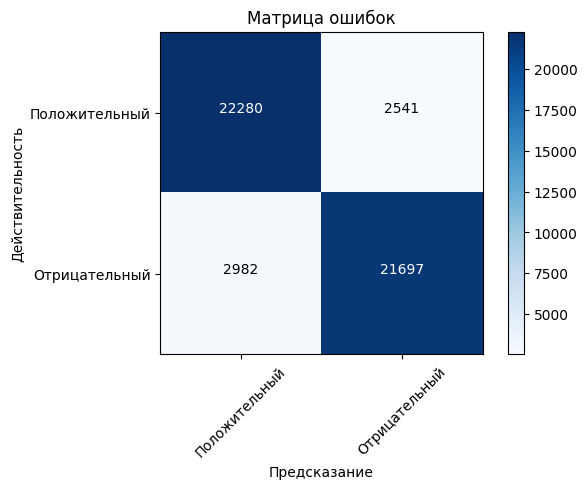

In [ ]:
cm_plot_labels = ['Положительный','Отрицательный']
plot_confusion_matrix(cm, cm_plot_labels, title='Матрица ошибок')

In [ ]:
# Вычисляем кривую ROC

n_classes=1

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(np.array(y_test_vec_n), np.array(prediction_proba_n))
    roc_auc = auc(fpr, tpr)
    print('ROC_AUC %0.2f '% roc_auc)

ROC_AUC 0.95 


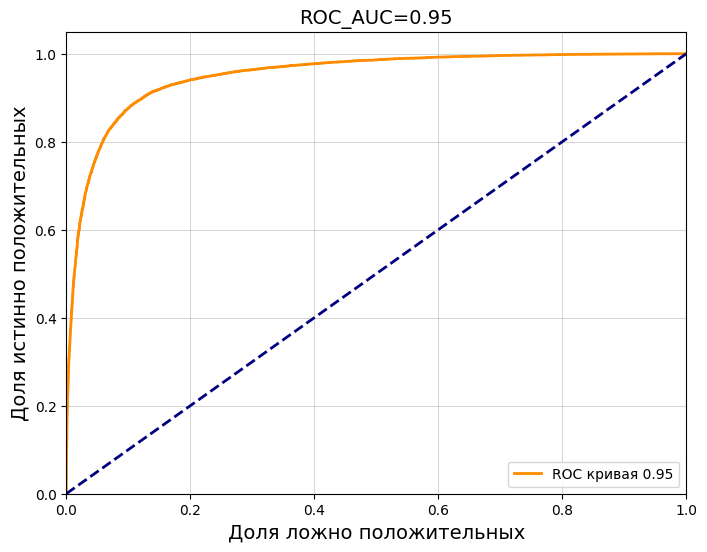

In [ ]:
plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC кривая %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложно положительных',fontsize=14)
plt.ylabel('Доля истинно положительных',fontsize=14)
plt.title('ROC_AUC=0.95',fontsize=14)
plt.legend(loc="lower right")
plt.grid(linewidth=0.5,alpha=0.75)
plt.savefig('roc_auc.png')
plt.show()

Используем векторные представления слов для анализа

In [ ]:
max_feature=10000
embedding_coeff_dict={}

for word,index in word_to_index.items():
  if ((index<max_feature)and(embedding_matrix[index] is not None)):
    embedding_coeff_dict[word]=embedding_matrix[index] #коэффициент в словарь

Вычисляем близость слов используя косинусное подобие
* Чем выше и ближе к 1 косинусное подобие, тем ближе слова друг к другу
*Высокое но отрицательное значение косинуса показывает что слова разные
*Близкие к 0 значения показывают отсутствие корреляции

In [ ]:
def most_similar_words(focus):
  most_similar=Counter()

  for word in word_to_index.keys():
    most_similar[word]=np.dot(embedding_coeff_dict[word],embedding_coeff_dict[focus])
  return most_similar.most_common()

In [ ]:
most_similar_words('bad') [0:10]

[('discolored', 0.90391153),
 ('aerogarden', 0.84484136),
 ('worst', 0.8149589),
 ('plasticbr', 0.80212843),
 ('returnable', 0.79335964),
 ('forcing', 0.7908119),
 ('unacceptable', 0.79025495),
 ('insult', 0.7811176),
 ('horriblebr', 0.77306646),
 ('steam', 0.76788133)]

In [ ]:
most_similar_words('perfect') [0:10]

[('pleasantly', 2.3198557),
 ('hooked', 2.1839623),
 ('lends', 2.1815526),
 ('drawback', 2.1791122),
 ('peterson', 2.116701),
 ('overboard', 2.0596263),
 ('continuing', 2.0310166),
 ('hears', 1.974098),
 ('awsome', 1.9658777),
 ('obsessed', 1.9336578)]

In [ ]:
np.dot(embedding_coeff_dict['best'],embedding_coeff_dict['worst'])

-1.6092302

In [ ]:
def predict_by_sentence(sentence):
  X_test_new=np.vstack((X_test, sentence_to_vector(sentence)))
  X_test_new= X_test_new[-100:,:]

  print(model_bestrun_gru.predict(X_test_new)[-1])
  if model_bestrun_gru.predict(X_test_new)[-1] > 0.6:
    print('Отзыв хороший')
  elif model_bestrun_gru.predict(X_test_new)[-1] >0.4 and model_bestrun_gru.predict(X_test_new)[-1]<0.6:
    print('Отзыв нейтральный')
  elif model_bestrun_gru.predict(X_test_new)[-1]<0.4:
    print("Отзыв плохой")




In [ ]:
predict_by_sentence('I love the quality of this product. Also the price is reasonable. ')

4/4 [==============================] - 1s 30ms/step
[0.88091683]
4/4 [==============================] - 0s 30ms/step
Отзыв хороший


In [ ]:
predict_by_sentence('I hate the quality of this product. Also the price is too high. Dissapointed')

4/4 [==============================] - 0s 32ms/step
[0.4992607]
4/4 [==============================] - 0s 33ms/step
Отзыв нейтральный


##Визуализация структуры слов с использованием T-SNE (подход без учителя)

*  Рассмотрим 500 лучших полярных слов.
*  Назначим 2 разных цвета для положительных и отрицательных отзывов.
*  Создадим t-SNE с двумя измерениями.



In [ ]:
import matplotlib.colors as colors

words_to_visualize = list()
for word, ratio in counter_pos_neg.most_common(500):
    if(word in embedding_coeff_dict.keys()):
        words_to_visualize.append(word)

for word, ratio in list(reversed(counter_pos_neg.most_common()))[0:500]:
    if(word in embedding_coeff_dict.keys()):
        words_to_visualize.append(word)

In [ ]:
# цветовая карта
pos = 0
neg = 0

colors_list = list()
vectors_list = list()
for word in words_to_visualize:
    if word in counter_pos_neg.keys():
        vectors_list.append(embedding_coeff_dict[word])
        if(counter_pos_neg[word] > 0):
            pos+=1
            colors_list.append("#a3ffa7")
        else:
            neg+=1
            colors_list.append("#ff4536")

## Применение t-SNE для представления данных в двумерном виде

In [ ]:
#создаем экземпляр t-SNE из sklearn в двух измерениях с векторным представлением слов в качестве входных данных
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
vectors_list = np.array(vectors_list)
words_top_ted_tsne = tsne.fit_transform(vectors_list)

In [ ]:
import bokeh
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="T-SNE для двух кластеров")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_to_visualize,
                                    color=colors_list))

p.scatter(x="x1", y="x2", size=7, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#7f7f84",
                  source=source, text_align='center')
p.add_layout(word_labels)

show(p)